<h1> Data Cleaning and Preperation <h1>

In [468]:
# Import statements for all of the packages that I plan to use.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [469]:
df = pd.read_csv('../movies_metadata.csv')

C:\Users\Tasli\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [470]:
df.shape

(45466, 24)

In [471]:
#Lets drop duplicates 
df.drop_duplicates(inplace=True)
df.shape

(45453, 24)

In [472]:
#Lets see if there are any null values
df.isnull().sum()
#we first want to remove the un-used columns then remove null values

adult                        0
belongs_to_collection    40959
budget                       0
genres                       0
homepage                 37673
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25045
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [473]:
#Remove un-used colmns
df.drop(columns=['id','adult','belongs_to_collection','homepage','imdb_id','original_language','original_title','overview','poster_path','production_companies','production_countries','release_date','revenue','spoken_languages','status','tagline','video'], inplace =True)

In [474]:
df.shape

(45453, 7)

In [475]:
#Since we need these remaining columns, lets see null and remove them
print(df.isnull().sum())

df.dropna(inplace=True)
print(df.shape)

budget            0
genres            0
popularity        5
runtime         263
title             6
vote_average      6
vote_count        6
dtype: int64
(45190, 7)


In [476]:
#lets see the types of data stored in the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45190 entries, 0 to 45465
Data columns (total 7 columns):
budget          45190 non-null object
genres          45190 non-null object
popularity      45190 non-null object
runtime         45190 non-null float64
title           45190 non-null object
vote_average    45190 non-null float64
vote_count      45190 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ MB


In [477]:
df.head(2)

,budget,genres,popularity,runtime,title,vote_average,vote_count
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",21.9469,81.0,Toy Story,7.7,5415.0
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",17.0155,104.0,Jumanji,6.9,2413.0


In [478]:
#The budget and popularity are not numeric. Lets convert them
df['budget'] = pd.to_numeric(df['budget'],errors='coerce')
#lets see the type and also the null values after converting
print(df.info())
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45190 entries, 0 to 45465
Data columns (total 7 columns):
budget          45190 non-null int64
genres          45190 non-null object
popularity      45190 non-null object
runtime         45190 non-null float64
title           45190 non-null object
vote_average    45190 non-null float64
vote_count      45190 non-null float64
dtypes: float64(3), int64(1), object(3)
memory usage: 2.8+ MB
None


budget          0
genres          0
popularity      0
runtime         0
title           0
vote_average    0
vote_count      0
dtype: int64

In [479]:
#lets do the same for popularity

#The popularity is not numeric. Lets convert 
df['popularity'] = pd.to_numeric(df['popularity'],errors='coerce')
#lets see the type and info about popularity
df['popularity'].describe()

count    45190.000000
mean         2.936888
std          6.019567
min          0.000000
25%          0.394017
50%          1.135799
75%          3.720080
max        547.488298
Name: popularity, dtype: float64

<h1> Clean up data by removing 0 values and process Json <h1>

In [480]:
df.title.describe()

count          45190
unique         42027
top       Cinderella
freq              11
Name: title, dtype: object

In [481]:
#lets remove the titles which are repeated and then remove title column

df.drop_duplicates('title',keep='last',inplace=True)
df.drop(columns=['title'],inplace=True)
df.shape

(42027, 6)

(42027, 6)


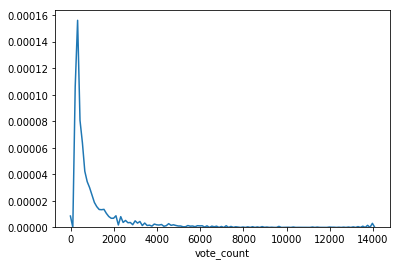

In [482]:
#Lets start by checking vote count - we dont use this column but we need to make sure all movies have been voted

sns.distplot(df['vote_count'],hist=False)
print(df.shape)

In [483]:
#A lot of 0s it seems, remove them and then drop the column

index_zero_vote= df[df['vote_count'] ==0].index
df.drop(index_zero_vote,axis=0,inplace=True) #Axis = 0 -> Rows

#drop column coz we dont need anymore
df.drop(columns=['vote_count'],inplace=True)
print(df.shape)

(39326, 5)


In [484]:
#Lets do the same for budget

index_zero_budget= df[df['budget'] ==0].index
df.drop(index_zero_budget,axis=0,inplace=True)
print(df.shape)

(7934, 5)


In [485]:
#Same for run time
index_zero_runtime = df[df['runtime'] ==0].index

df.drop(index_zero_runtime,axis=0,inplace=True)
print(df.shape)

(7883, 5)


In [486]:
#Same for vote_Average
index_zero_vote_avg = df[df['vote_average'] ==0].index
df.drop(index_zero_vote_avg,axis=0,inplace=True)
print(df.shape)

(7878, 5)


In [487]:
#same for popularity
index_zero_pop = df[df['popularity'] ==0].index
df.drop(index_zero_pop,axis=0,inplace=True)
print(df.shape)


(7878, 5)


In [488]:
#lets see what we have left
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7878 entries, 0 to 45422
Data columns (total 5 columns):
budget          7878 non-null int64
genres          7878 non-null object
popularity      7878 non-null float64
runtime         7878 non-null float64
vote_average    7878 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 369.3+ KB


<h2> Processing Genres <h2>

In [489]:
#lets extract the main Genre of each movie to work with 
def get_main_genre(listofJson):
    listofJson =listofJson.replace("'",'"')
    jdata = json.loads(listofJson)
    try:
        return jdata[0]["name"]
    except IndexError:
        return 'null'

df["genres"] = df["genres"].apply(get_main_genre)
df.head(3)

,budget,genres,popularity,runtime,vote_average
0,30000000,Animation,21.946943,81.0,7.7
1,65000000,Adventure,17.015539,104.0,6.9
3,16000000,Comedy,3.859495,127.0,6.1


In [490]:
#Are there any nulls?

df["genres"].value_counts()

Drama              1936
Comedy             1548
Action             1276
Horror              615
Adventure           499
Crime               356
Thriller            337
Animation           209
Documentary         178
Fantasy             171
Romance             164
Science Fiction     159
Mystery              95
Family               76
War                  53
Music                53
History              47
Western              45
null                 36
TV Movie             19
Foreign               6
Name: genres, dtype: int64

In [491]:
#Remove the null
index_null_genre = df[df['genres'] =="null"].index
df.drop(index_null_genre,axis=0,inplace=True)
print(df.shape)

(7842, 5)


In [492]:
#lets only keep the Genres with 200 + data in them

df = df[df["genres"].isin(["Drama","Comedy","Action","Horror","Adventure","Crime" ,"Thriller"])]
df.shape

(6567, 5)

<h2> Categorizing Rating <h2>

count    6567.000000
mean        6.047663
std         1.073447
min         0.500000
25%         5.400000
50%         6.100000
75%         6.800000
max        10.000000
Name: vote_average, dtype: float64

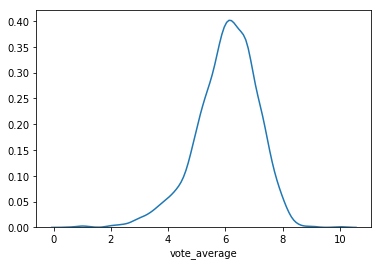

In [493]:
sns.distplot(df['vote_average'], hist=False)
df['vote_average'].describe()

In [494]:
#lets make 4 final label classes based on the vote average

def categorize_success(rating):
    if rating >= 7.5:
        return 'Good'
    if rating >= 5:
        return 'Average'
    else:
        return 'Bad'
    
df["rating_label"] = df["vote_average"].apply(categorize_success)

df.head(3)

,budget,genres,popularity,runtime,vote_average,rating_label
1,65000000,Adventure,17.015539,104.0,6.9,Average
3,16000000,Comedy,3.859495,127.0,6.1,Average
8,35000000,Action,5.231580,106.0,5.5,Average


In [495]:
#lets see the values
df['rating_label'].value_counts()

Average    5204
Bad         884
Good        479
Name: rating_label, dtype: int64

In [496]:
#Doing the slit on selected range is ineffective, lets decide range baed on quartiles

def split_on_quartiles(dfname ,column_name,new_column_name):
# find quartile, max and min values
    min_value = dfname[column_name].min()
    first_quantile = dfname[column_name].describe()[4]
    second_quantile = dfname[column_name].describe()[5]
    third_quantile = dfname[column_name].describe()[6]
    max_value = dfname[column_name].max()
# Bin edges that will be used to "cut" the data into groups
    bin_edges = [ min_value, first_quantile, second_quantile, third_quantile, max_value]
# Labels for the four budget level groups
    bin_names = [ 'Low', 'Medium', 'High', 'Very_High'] 
# Creates budget_levels colums
    dfname[new_column_name] = pd.cut(dfname[column_name], bin_edges, labels=bin_names, include_lowest = True)
    return dfname


In [497]:
df = split_on_quartiles(df,'vote_average','rating_label_quartile')
#df['rating_label_quartile'].value_counts()

df['rating_label_quartile'].value_counts()

High         1775
Low          1668
Medium       1653
Very_High    1471
Name: rating_label_quartile, dtype: int64

In [498]:
#Lets now drop the vote average because we have the labels
df.drop(columns=['vote_average'],inplace=True)

#Using the quartile did not give us good results for the model, so lets drop it and stick to our normal range

df.drop(columns=['rating_label_quartile'],inplace=True)

## Over Sample minority classes - Under Sample Majority - 2000 of each

In [499]:
from sklearn.utils import resample
print(df.shape)

(6567, 5)


In [500]:
df_majority = df[df.rating_label =='Average']

df_minority_good = df[df.rating_label =='Good']
print(df_minority_good.shape)

#Down sample Average
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=2000,     # to match limit
                                 random_state=123) # reproducible results

# Upsample minority class
df_minority_good_upsampled = resample(df_minority_good, 
                                 replace=True,     # sample with replacement
                                 n_samples=2000,    # to match limit 
                                 random_state=123) # reproducible results

df_minority_good_upsampled.shape

(479, 5)


(2000, 5)

In [501]:
df_minority_bad = df[df.rating_label =='Bad']
print(df_minority_bad.shape)


# Upsample minority class
df_minority_bad_upsampled = resample(df_minority_bad, 
                                 replace=True,     # sample with replacement
                                 n_samples=2000,    # to match  limit
                                 random_state=123) # reproducible results

df_minority_bad_upsampled.shape

(884, 5)


(2000, 5)

In [502]:
df = pd.concat([df_majority_downsampled, df_minority_good_upsampled,df_minority_bad_upsampled])
print('New data set size', df.shape)
print(df.rating_label.value_counts())
df.head(2)

New data set size (6000, 5)
Bad        2000
Good       2000
Average    2000
Name: rating_label, dtype: int64


,budget,genres,popularity,runtime,rating_label
7796,360000,Action,1.345165,113.0,Average
6173,7000000,Action,1.782377,113.0,Average


<h2> Prepare Data for ML models <h2>

In [503]:
#Rearrange df columns

In [504]:
#lets get the numeric values (can normalize them later)

df2 = df[['budget','popularity','runtime']]

df2 = (df2-df2.min())/(df2.max()-df2.min())

df2.insert(len(df2.columns),'genres',df[['genres']])
df2.insert(len(df2.columns),'rating_label',df[['rating_label']])

df2.head(2)

,budget,popularity,runtime,genres,rating_label
7796,0.000947,0.006290,0.151862,Action,Average
6173,0.018421,0.008335,0.151862,Action,Average


In [505]:
#Rearrange df columns to match format
cols = ['budget','popularity','runtime','genres','rating_label']
df = df[cols]
df.head(2)

,budget,popularity,runtime,genres,rating_label
7796,360000,1.345165,113.0,Action,Average
6173,7000000,1.782377,113.0,Action,Average


In [506]:
print(df.shape)
print(df2.shape)

(6000, 5)
(6000, 5)


In [507]:
#the last step of pre-processing, applying one-hot encoding to genres(string) columns
one_hot = pd.get_dummies(df['genres'])

df.drop(columns=['genres'],inplace=True)
df2.drop(columns=['genres'],inplace=True)
print(df.shape)
print(one_hot.shape)
df = pd.concat([df,one_hot], axis=1)
df2 = pd.concat([df2,one_hot],axis=1)

print(df.shape)
df.head(2)


(6000, 4)
(6000, 7)
(6000, 11)


,budget,popularity,runtime,rating_label,Action,Adventure,Comedy,Crime,Drama,Horror,Thriller
7796,360000,1.345165,113.0,Average,1,0,0,0,0,0,0
6173,7000000,1.782377,113.0,Average,1,0,0,0,0,0,0


In [508]:
cols_final =['budget', 'popularity', 'runtime', 'Action','Adventure', 'Comedy', 'Crime', 'Drama', 'Horror', 'Thriller','rating_label']
df = df.reindex(columns=cols_final)

df2= df2.reindex(columns= cols_final)

print(df.head(2))
print(df2.head(2))

       budget  popularity  runtime  Action  Adventure  Comedy  Crime  Drama  \
7796   360000    1.345165    113.0       1          0       0      0      0   
6173  7000000    1.782377    113.0       1          0       0      0      0   

      Horror  Thriller rating_label  
7796       0         0      Average  
6173       0         0      Average  
        budget  popularity   runtime  Action  Adventure  Comedy  Crime  Drama  \
7796  0.000947    0.006290  0.151862       1          0       0      0      0   
6173  0.018421    0.008335  0.151862       1          0       0      0      0   

      Horror  Thriller rating_label  
7796       0         0      Average  
6173       0         0      Average  


In [509]:
#Saving the normal (not normalized) into numpy array and then pickle out

arr = np.array(df)
X = arr[:,0:-1]
Y= arr[:,-1]
print(arr.shape)
np.save('data_array_non_formatted',arr)

(6000, 11)


In [510]:
#Saving the  normalized data into numpy array and then pickle out

arr_f = np.array(df2)
print(arr_f.shape)
np.save('data_array_formatted',arr_f)

(6000, 11)
